In [1]:
import numpy
import warnings
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import random
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz, load_npz
from scipy.stats import pearsonr
from typing import Dict, Tuple
from tqdm import tqdm
from collections import defaultdict
import polars as pl
import json
from scipy import stats
import multiprocessing

import MultiChat as MC

# Processing

In [8]:
base_path = '/home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/'
db = pd.read_csv(os.path.join(base_path, "inputs/LRpairDB_merge.csv"), header=0, sep=",")
cell_rep = pd.read_csv(os.path.join(base_path, "HGEmb/Cell_rep.csv"), header=0, index_col=0, sep=",")
expmatrix = pd.read_csv(os.path.join(base_path, "inputs/RNAmatrix.csv"), header=0, index_col=0, sep=",")
non_zero_counts = (expmatrix > 0).sum(axis=1)
expmatrix_filt1 = expmatrix[non_zero_counts >= 5]
split_ligand_symbols = db['Ligand_Symbol'].str.split('_') 
mask_ligand = split_ligand_symbols.apply(lambda symbols: all(symbol in expmatrix_filt1.index for symbol in symbols)) 
db_filt1 = db[mask_ligand] 
split_receptor_symbols = db_filt1['Receptor_Symbol'].str.split('_') 
mask_receptor = split_receptor_symbols.apply(lambda symbols: all(symbol in expmatrix_filt1.index for symbol in symbols)) 
db_filt1 = db_filt1[mask_receptor] 
lig_exp, rec_exp = MC.Processing.Preprocess_CCC_model(base_path, db_filt1, cell_rep, expmatrix_filt1)

# InterCCC run

In [13]:
'''get postive pairs'''
cell_clus = pd.read_csv(base_path + '/inputs/Cell_type_info.csv', header=0, index_col=0, sep=",")
cell_clus.rename(columns={'celltype': 'cell_type'}, inplace=True)
cell_loc = pd.read_csv(base_path + '/inputs/Coord.csv', header=0, index_col=0)
parser                  =  MC.utilities.parameter_setting()
args, unknown           = parser.parse_known_args()
args.inputPath          = '/home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/'
args.outPath            = args.inputPath + 'CCC/'
MC.utilities.get_cell_positive_pairs(cell_clus, cell_loc, args)

In [ ]:
parser  =  MC.utilities.parameter_setting() 
args, unknown = parser.parse_known_args()

args.gpu_id = 0
if args.use_cuda and torch.cuda.is_available():
    device = torch.device(f'cuda:{args.gpu_id}')
    torch.cuda.set_device(args.gpu_id)
else:
    device = torch.device('cpu')

## random seed 
numpy.random.seed( args.seed )
random.seed( args.seed )
torch.manual_seed( args.seed )
torch.cuda.manual_seed( args.seed )

start = time.time()
args.inputPath          = '/home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/'
args.use_cuda           = args.use_cuda and torch.cuda.is_available()

args.outPath            = args.inputPath + 'CCC/'	
args.spatialLocation    = args.inputPath + 'inputs/' + 'Coord.csv'
args.annoFile           = args.inputPath + 'inputs/' + 'Celltype_info.csv'
args.pos_pair           = args.outPath + args.pos_pair

args.Ligands_exp        = args.outPath + args.Ligands_exp
args.Receptors_exp      = args.outPath + args.Receptors_exp

args.patience           = 15
args.lr_cci             = 0.001
args.attn_drop          = 0
args.tau                = 0.05

args.selected_cell_type = None
args.InterCCC_Name      = 'LRI_module_strength.txt'

MC.model_training.Train_CCC_model(args)
	
duration = time.time() - start
print('Finish training, total time is: ' + str(duration) + 's' )

spot location for adjancy
spot-ligand data
spot-receptor data
Size of CCC pairs: 2369
Start model training
0 cost: tensor(201.0987)
10 cost: tensor(10.8675) tensor(0.0328, device='cuda:0', grad_fn=<DivBackward0>)
20 cost: tensor(3.3257) tensor(0.0706, device='cuda:0', grad_fn=<DivBackward0>)
30 cost: tensor(1.5707) tensor(0.0520, device='cuda:0', grad_fn=<DivBackward0>)
40 cost: tensor(1.0761) tensor(0.0298, device='cuda:0', grad_fn=<DivBackward0>)
50 cost: tensor(0.8233) tensor(0.0243, device='cuda:0', grad_fn=<DivBackward0>)
60 cost: tensor(0.6669) tensor(0.0180, device='cuda:0', grad_fn=<DivBackward0>)
70 cost: tensor(0.5704) tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>)
80 cost: tensor(0.5020) tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>)
90 cost: tensor(0.4493) tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>)
100 cost: tensor(0.4066) tensor(0.0095, device='cuda:0', grad_fn=<DivBackward0>)
110 cost: tensor(0.3708) tensor(0.0089, device='cuda:0', grad_fn=<

## Generate Background InterCCC data

In [15]:
'''Step1:get random postive pairs'''
pos_pair = pd.read_csv(base_path + 'CCC/Spot_positive_pairs.txt', header=None, index_col=None, sep="\t")
pos_pair_perturb = pos_pair.apply(MC.utilities.perturb_pos_pair_row, axis=1)
lig_exp = pd.read_csv(base_path + 'CCC/ligands_expression.txt', header=0, index_col=0, sep="\t")
rec_exp = pd.read_csv(base_path + 'CCC/receptors_expression.txt', header=0, index_col=0, sep="\t")
lig_exp_shuffled = lig_exp.apply(np.random.permutation)
rec_exp_shuffled = rec_exp.apply(np.random.permutation)
lig_exp_shuffled.to_csv(base_path + 'Bg_CCC/ligands_expression_shuffled.txt', sep="\t")
rec_exp_shuffled.to_csv(base_path + 'Bg_CCC/receptors_expression_shuffled.txt', sep="\t")
pos_pair_perturb.to_csv(base_path + 'Bg_CCC/Spot_positive_pairs_shuffled.txt', sep="\t", header=False, index=False)

In [ ]:
'''Step2-1:Run RegChat_Inter to generate 10 sets of background data in parallel'''
def run_training(run_idx):  
    parser = MC.__cached__utilities.parameter_setting()
    args, unknown = parser.parse_known_args()
    args.gpu_id = 1
    
    base_seed = 42  
    args.seed = base_seed + run_idx
    
    if args.use_cuda and torch.cuda.is_available():
        device = torch.device(f'cuda:{args.gpu_id}')
        torch.cuda.set_device(device)  
    else:
        device = torch.device('cpu')
    
    np.random.seed(args.seed)
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    
    start = time.time()
    start = time.time()
    args.inputPath          = '/home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/'
    args.use_cuda           = args.use_cuda and torch.cuda.is_available()

    args.outPath            = args.inputPath + 'Bg_CCC/'	
    args.spatialLocation    = args.inputPath + 'inputs/' + 'Coord.csv'
    args.annoFile           = args.inputPath + 'inputs/' + 'Celltype_info.csv'
    args.pos_pair           = args.outPath + 'Spot_positive_pairs_shuffled.txt'
    args.Ligands_exp        = args.outPath + 'ligands_expression_shuffled.txt'
    args.Receptors_exp      = args.outPath + 'receptors_expression_shuffled.txt'
    
    args.patience = 15
    args.lr_cci = 0.001
    args.attn_drop = 0
    args.tau = 0.05
    
    args.lrp_strength_file = args.outPath + f'LRI_module_strength_run_{run_idx}.txt'
    
    # Run training
    MC.model_training.Train_CCC_model_parallel(args)
    
    duration = time.time() - start
    print(f'Finish training run {run_idx}, total time: {duration}s')

In [ ]:
'''Step2-2:Run RegChat_Inter to generate 10 sets of background data in parallel'''
if __name__ == '__main__':
    run_indices = list(range(1, 11))  # [1, 2, 3, ..., 10]
    
    with multiprocessing.Pool(processes=3) as pool:
        pool.map(run_training, run_indices)

spot location for adjancy
spot location for adjancy
spot location for adjancy
spot-ligand data
spot-ligand data
spot-ligand data
spot-receptor data
spot-receptor dataspot-receptor data

Size of CCC pairs: 2369
Size of CCC pairs: 2369
Size of CCC pairs: 2369
Start model trainingStart model trainingStart model training


Using GPU: 1
Using GPU: 1
Using GPU: 1
0 cost: 854.0214843750 cost: 870.98400878906250 cost: 912.388427734375


10 cost: 738.489990234375 1.4876524801366031e-05
10 cost: 738.4947509765625 2.1653322619386017e-05
10 cost: 738.3778686523438 7.77008699515136e-06
20 cost: 738.4407348632812 4.297995019442169e-06
20 cost: 738.4263305664062 5.703211627405835e-06
20 cost: 738.3501586914062 3.4718862025329145e-06
30 cost: 738.4119262695312 3.88487933378201e-06
30 cost: 738.3897094726562 4.959564193995902e-06
30 cost: 738.3189697265625 4.877372703049332e-06
40 cost: 738.3815307617188 4.380999598652124e-06
40 cost: 738.3519897460938 5.455796781461686e-06
40 cost: 738.27587890625 6.6

# Identify Significant L->R pair

## Identify singl-cell level significant L->R pair

In [ ]:
base_path = '/home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/'
background_inter_df = MC.Intra_strength.load_background_inter(base_path+'Bg_CCC/', file_pattern="LRI_module_strength_run_*.txt")
background_inter_df.to_csv(base_path + 'Bg_CCC/LRI_module_strength_concat.txt', sep="\t", index=True)
sample_inter_df = pd.read_csv(base_path+'CCC/LRI_module_strength.txt', sep='\t', index_col=0)
lr_lst = sample_inter_df.columns.tolist()
sub_background_inter_df = background_inter_df.loc[:, lr_lst]

In [19]:
sig_LR_pair = MC.Intra_strength.Identify_significant_lr_pairs(
    background_inter_df=sub_background_inter_df,
    sample_inter_df=sample_inter_df,
    output_path=base_path+'CCC/Significant_LRs.csv',
    z_critical=None,
    alpha=0.05
)
sig_LR_pair.head()

Processing samples: 9674it [00:09, 1030.93it/s]


Significant_L->R pairs saved to /home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/CCC/Significant_LRs.csv


,Sample_Name,LR_Symbol,Inter_Score,Z_Score
0,CK167#GCATTGAGTATTCTTC-1,KITLG->PDGFRB,0.049531,8.192005
1,CK167#GCATTGAGTATTCTTC-1,ICAM1->ITGAX_ITGB2,0.029511,8.147907
2,CK167#GCATTGAGTATTCTTC-1,JAG2->NOTCH3,0.021187,5.382108
3,CK167#GCATTGAGTATTCTTC-1,LAMB1->ITGA7_ITGB1,0.089872,4.477362
4,CK167#GCATTGAGTATTCTTC-1,LAMA5->ITGA7_ITGB1,0.027699,4.052580


## Identify Cell-type level Significant L->R pair

In [23]:
cell_clus = pd.read_csv(base_path+'/inputs/Celltype_info.csv', header=0, index_col=0, sep="\t")
sig_LR_pair_celltype = MC.Intra_strength.Identify_significant_lr_pairs_celltype(sig_LR_pair, cell_clus, agg_method='mean')
merged = sample_inter_df.join(cell_clus)   
sample_inter_ct_df = merged.groupby('celltype').mean() 
sample_inter_ct_df.index.name = None 
vola_LR_pair_celltype, vola_LR_pair_celltype_vscore,vola_LR_pair_celltype_bin,_ = MC.Intra_strength.Identify_volatile_lr_pairs_celltype(sample_inter_ct_df, threshold=2.5, method='mad')
outs_path = base_path+'CCC/Significant_LRs_ct_concat.csv' 
sig_LR_pair_celltype_concat = MC.Intra_strength.Identify_concat_lr_pairs_celltype(sig_LR_pair_celltype,vola_LR_pair_celltype,outs_path)

sig_LR_pair_celltype_updated saved to /home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/CCC/Significant_LRs_ct_concat.csv


# IntraCCC run

## Load data

In [ ]:
rna_mat = pd.read_csv(base_path + 'CCC/expression_smooth.txt', header=0, index_col=0, sep="\t")
atac_mat = pl.read_csv(base_path + 'inputs/ATACmatrix.csv')
atac_mat = atac_mat.to_pandas().set_index(atac_mat.columns[0])
tg_re_df = pd.read_csv(base_path + 'inputs/TG_RE_score_df_up2kb_cutoff02_overlap.csv', sep="\t")
gene_rep = pd.read_csv(base_path + 'HGEmb/Gene_rep.csv', index_col=0)
cell_rep = pd.read_csv(base_path + 'HGEmb/Cell_rep.csv', index_col=0)
sample_order = rna_mat.columns.tolist()
cell_rep_aligned = cell_rep.loc[sample_order]
tf_rep = pd.read_csv(base_path + 'HGEmb/TF_rep.csv', index_col=0)
lst = tf_rep.index.tolist()
new_lst = [item.replace('M_', '', 1) for item in lst]
tf_rep.index = new_lst
peak_rep = pd.read_csv(base_path + 'HGEmb/Peak_rep.csv', index_col=0)
tf_re_ba = pd.read_csv(base_path + 'HGEmb/TF_RE_ba.csv', index_col=0)
l_r_df = pd.read_csv(base_path + 'inputs/LRpairDB_merge_filt1.csv') 
r_tf_cellcall = pd.read_csv(base_path + 'inputs/new_ligand_receptor_TFs.txt', sep='\t')

## Build L-R-TF-TG database

In [ ]:
tf_tg_common_peaks = MC.Intra_strength.build_tf_tg_mapping(tg_re_df, tf_re_ba)
l_r_tf_df = MC.Intra_strength.generate_l_r_tf_pairs(l_r_df, r_tf_cellcall)
l_r_tf_df.to_csv(base_path + 'inputs/Ligand_Receptor_TF_pairs.csv', sep="\t", index=False)
L_R_TF_TG_df = MC.Intra_strength.generate_l_r_tf_tg_pairs(l_r_tf_df, tf_tg_common_peaks)
L_R_TF_TG_df.to_csv(base_path + 'inputs/Ligand_Receptor_TF_TG_pairs.csv', sep="\t", index=False)

Processing L-R-TF-TG pairs: 12572it [00:34, 366.09it/s]


In [ ]:
unique_counts = L_R_TF_TG_df.nunique()
unique_counts

Ligand_Symbol      188
Receptor_Symbol    192
TF_Symbol          110
TG_Symbol          140
dtype: int64

## Get TF-TG Strength

In [ ]:
rna_mat_minmax = (rna_mat - rna_mat.min()) / (rna_mat.max() - rna_mat.min()) # column-wise normalization
atac_mat_minmax = atac_mat.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1) # row-wise normalization

In [ ]:
path_outs = base_path + 'CCC/TF_TG/'
tf_tg_scores = MC.Intra_strength.calculate_all_tf_tg_scores(
    rna_mat=rna_mat_minmax,
    atac_mat=atac_mat_minmax,
    tg_re_df=tg_re_df,
    tf_rep=tf_rep,
    peak_rep=peak_rep,
    tf_re_ba=tf_re_ba,
    gene_rep=gene_rep,
    path=path_outs
)

tf_tg_scores.head()

Processing cells: 100%|██████████| 9674/9674 [4:44:10<00:00,  1.76s/it]  


,EP300->PIK3R3,EP300->SMAP2,EP300->PPP1R12B,EP300->PLA2G5,EP300->KAZN,EP300->NGF,EP300->CD247,EP300->ACTN2,EP300->MYOM3,EP300->NEXN,...,FOXO1->CLMN,FOXO1->ADCY4,FOXO1->DTNA,FOXO1->LAMA3,FOXO1->CDH2,FOXO1->TCF4,FOXO1->RAB31,FOXO1->PTPRM,FOXO1->FHOD3,FOXO1->COLEC12
CK167#GCATTGAGTATTCTTC-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.005746,0.0,0.0,0.0,0.0
CK168#AGCCAGCAGTCTCCAA-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.018724,0.0,0.0,0.0,0.0
CK387#AACGGGAGTCAGACGA-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CK170#CGCTAGGAGCAGAAAG-1,0.0,0.0,0.0,0.0,0.0,0.000491,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CK170#ACTGTCCCAAAGCTGG-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
tf_tg_scores_df = tf_tg_scores.loc[:, (tf_tg_scores != 0).any()]
tf_tg_scores_df.head()

,EP300->PIK3R3,EP300->SMAP2,EP300->PPP1R12B,EP300->PLA2G5,EP300->KAZN,EP300->NGF,EP300->CD247,EP300->ACTN2,EP300->MYOM3,EP300->NEXN,...,FOXO1->DPF3,FOXO1->CLMN,FOXO1->ADCY4,FOXO1->DTNA,FOXO1->CDH2,FOXO1->TCF4,FOXO1->RAB31,FOXO1->PTPRM,FOXO1->FHOD3,FOXO1->COLEC12
CK167#GCATTGAGTATTCTTC-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.005746,0.0,0.0,0.0,0.0
CK168#AGCCAGCAGTCTCCAA-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.001972,0.0,0.0,0.0,0.0,0.018724,0.0,0.0,0.0,0.0
CK387#AACGGGAGTCAGACGA-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CK170#CGCTAGGAGCAGAAAG-1,0.0,0.0,0.0,0.0,0.0,0.000491,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CK170#ACTGTCCCAAAGCTGG-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Get R-TF PCC

In [ ]:
l_r_tf_df = pd.read_csv(base_path + 'inputs/Ligand_Receptor_TF_pairs.csv', sep="\t")
l_r_tf_df.head()

,Ligand_Symbol,Receptor_Symbol,TF_Symbol
0,TGFB1,TGFBR2_TGFBR1,ATF4
1,TGFB1,TGFBR2_TGFBR1,ATF2
2,TGFB1,TGFBR2_TGFBR1,DAXX
3,TGFB1,TGFBR2_TGFBR1,DDIT3
4,TGFB1,TGFBR2_TGFBR1,E2F1


In [ ]:
rec_tf_df = l_r_tf_df[['Receptor_Symbol', 'TF_Symbol']].drop_duplicates()
rec_tf_df = rec_tf_df.reset_index(drop=True)
rec_tf_df.head()

,Receptor_Symbol,TF_Symbol
0,TGFBR2_TGFBR1,ATF4
1,TGFBR2_TGFBR1,ATF2
2,TGFBR2_TGFBR1,DAXX
3,TGFBR2_TGFBR1,DDIT3
4,TGFBR2_TGFBR1,E2F1


In [ ]:
rec_tf_pcc = rec_tf_df.copy()
rec_tf_pcc['scores'] = rec_tf_pcc.apply(
    lambda row: MC.Intra_strength.calculate_pcc_rec_tf(gene_rep, tf_rep, row['Receptor_Symbol'], row['TF_Symbol']), axis=1
)
rec_tf_pcc = rec_tf_pcc.fillna(0)
rec_tf_pcc.to_csv(base_path + 'CCC/Receptor_TF_PCC.csv', index=False)
rec_tf_pcc.head()

,Receptor_Symbol,TF_Symbol,scores
0,TGFBR2_TGFBR1,ATF4,0.692339
1,TGFBR2_TGFBR1,ATF2,0.634042
2,TGFBR2_TGFBR1,DAXX,0.000000
3,TGFBR2_TGFBR1,DDIT3,0.686675
4,TGFBR2_TGFBR1,E2F1,0.511952


## Get R-TF-TG Strength

In [ ]:
tf_tg_scores_df = pd.read_csv(base_path + 'CCC/TF_TG/all_samples_tf_tg_scores.csv', sep=',', index_col=0)
rec_tf_pcc = pd.read_csv(base_path + 'CCC/Receptor_TF_PCC.csv', sep=',')

In [ ]:
tf_tg_scores_df = tf_tg_scores_df.loc[:, (tf_tg_scores_df != 0).any()] 
tf_tg_scores_df.head()

,EP300->PIK3R3,EP300->SMAP2,EP300->PPP1R12B,EP300->PLA2G5,EP300->KAZN,EP300->NGF,EP300->CD247,EP300->ACTN2,EP300->MYOM3,EP300->NEXN,...,FOXO1->DPF3,FOXO1->CLMN,FOXO1->ADCY4,FOXO1->DTNA,FOXO1->CDH2,FOXO1->TCF4,FOXO1->RAB31,FOXO1->PTPRM,FOXO1->FHOD3,FOXO1->COLEC12
CK167#GCATTGAGTATTCTTC-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.005746,0.0,0.0,0.0,0.0
CK168#AGCCAGCAGTCTCCAA-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.001972,0.0,0.0,0.0,0.0,0.018724,0.0,0.0,0.0,0.0
CK387#AACGGGAGTCAGACGA-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CK170#CGCTAGGAGCAGAAAG-1,0.0,0.0,0.0,0.0,0.0,0.000491,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CK170#ACTGTCCCAAAGCTGG-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
cell_results_reg, combined_results_reg = MC.Intra_strength.calculate_r_tf_tg_reg(
    cell_rep=cell_rep_aligned,
    tf_tg_score_df=tf_tg_scores_df,
    rec_tf_pcc=rec_tf_pcc,
    rna_mat=rna_mat_minmax,
    output_dir=base_path+"CCC/R_TF_TG_Reg"
)

Processing cells:   0%|          | 0/9674 [00:00<?, ?it/s]

Processing cells: 100%|██████████| 9674/9674 [30:05<00:00,  5.36it/s]  


In [ ]:
with open(base_path+'CCC/R_TF_TG_Reg/global_row_names.json', 'r') as f:
    global_row_names = json.load(f)
with open(base_path+'CCC/R_TF_TG_Reg/global_col_names.json', 'r') as f:
    global_col_names = json.load(f)

In [ ]:
cell_results_cor, combined_cor = MC.Intra_strength.calculate_r_tf_tg_cor(
    gene_rep=gene_rep,
    tf_rep=tf_rep,
    cell_rep=cell_rep_aligned,
    receptors=global_row_names,
    tf_tg_pairs=global_col_names,
    reg_dir = base_path+"CCC/R_TF_TG_Reg",
    output_dir=base_path+"CCC/R_TF_TG_Cor"
)

Precomputing PCC matrices...


Processing cells: 100%|██████████| 9674/9674 [08:55<00:00, 18.06it/s]


In [ ]:
cor_dir = base_path+"CCC/R_TF_TG_Cor"
reg_dir = base_path+"CCC/R_TF_TG_Reg"

cell_results_tol, combined_tol = MC.Intra_strength.calculate_r_tf_tg_strength(
    cell_rep =cell_rep_aligned,
    cor_dir=cor_dir,
    reg_dir=reg_dir,
    output_dir=base_path+"CCC/R_TF_TG"
)

Calculating total scores:   0%|          | 0/9674 [00:00<?, ?it/s]

Calculating total scores: 100%|██████████| 9674/9674 [00:55<00:00, 173.34it/s]


## Get L-R-TF-TG Strength

In [ ]:
'''Defulat--------ligandwise'''
MC.Intra_strength.calculate_l_r_tf_tg_strength(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"CCC/CCC_module_LRP_strength.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/ligand_cascade_results"
)

Loading data...
Data loaded successfully
Identifying zero L-R pairs...
Found 41 zero L-R pairs to skip


Processing ligands: 100%|██████████| 188/188 [2:52:01<00:00, 54.90s/it]   

Processing completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/L_R_TF_TG/ligand_cascade_results


In [ ]:
'''Defulat------------tgwise'''
MC.Intra_strength.calculate_l_r_tf_tg_strength_by_tg(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"CCC/CCC_module_LRP_strength.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/TG_cascade_results"
)

Loading data...
Identifying zero L-R pairs...
Found 41 zero L-R pairs to skip


Processing TGs: 100%|██████████| 140/140 [2:16:45<00:00, 58.61s/it] 

All TG networks saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/L_R_TF_TG/TG_cascade_results


## Background L-R-TF-TG Strength

In [ ]:
InterCCC_random = pl.read_csv(base_path + 'Bg_CCC/LRI_module_strength_concat.txt', separator="\t") 
InterCCC_random = InterCCC_random.to_pandas().set_index(InterCCC_random.columns[0])
InterCCC_random

,TGFB1->TGFBR2_TGFBR1,TGFB2->TGFBR2_TGFBR1,TGFB3->TGFBR2_TGFBR1,TGFB1->TGFBR2_ACVR1B,TGFB1->TGFBR2_ACVR1C,TGFB2->TGFBR2_ACVR1B,TGFB2->TGFBR2_ACVR1C,TGFB3->TGFBR2_ACVR1B,TGFB3->TGFBR2_ACVR1C,TGFB1->TGFBR2_ACVR1_TGFBR1,...,SERPINF1->LRP6,CCL3->CXCR5,CCL4->CXCR5,CCL5->CXCR5,CCL16->CXCR5,CXCL12->CCR10,VEGFA->PDGFRA,VEGFA->PDGFRB,NECTIN4->NECTIN1,NECTIN4->NECTIN2
,,,,,,,,,,,,,,,,,,,,,
CK167#GCATTGAGTATTCTTC-1,0.009634,0.011177,0.009328,0.005512,0.000000,0.016251,0.000000,0.016617,0.006744,0.003498,...,0.000291,0.000082,0.000000,0.000000,0.000000,0.000257,0.008158,0.000656,0.000176,0.0
CK168#AGCCAGCAGTCTCCAA-1,0.019065,0.017783,0.000902,0.006447,0.000000,0.008730,0.001610,0.010417,0.008017,0.002829,...,0.000248,0.000082,0.000000,0.000000,0.000000,0.000294,0.000000,0.000416,0.000176,0.0
CK387#AACGGGAGTCAGACGA-1,0.012818,0.012191,0.000690,0.004431,0.000789,0.025657,0.001497,0.008583,0.015831,0.001862,...,0.007331,0.000082,0.000000,0.000000,0.000000,0.000294,0.015407,0.000416,0.000176,0.0
CK170#CGCTAGGAGCAGAAAG-1,0.020068,0.000870,0.007916,0.004765,0.000661,0.006120,0.001346,0.005889,0.001417,0.001451,...,0.000218,0.000082,0.000000,0.000000,0.000000,0.000161,0.012305,0.000307,0.000176,0.0
CK170#ACTGTCCCAAAGCTGG-1,0.031438,0.009547,0.001590,0.008109,0.000447,0.003140,0.001548,0.000201,0.002101,0.001531,...,0.006103,0.000082,0.000000,0.000000,0.000000,0.003448,0.026046,0.000307,0.000176,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CK338#GAAGTCTGTTCAGAAA-1,0.013890,0.009525,0.000966,0.003010,0.001645,0.000934,0.000213,0.016059,0.004469,0.004739,...,0.002256,0.000000,0.000013,0.000121,0.000151,0.000788,0.001050,0.000144,0.000000,0.0
CK340#AGCCCGAGTTGGAGGT-1,0.012558,0.006123,0.000638,0.003592,0.004486,0.000000,0.000923,0.001974,0.004582,0.003518,...,0.000118,0.000000,0.000013,0.000105,0.000151,0.000948,0.000759,0.003921,0.000000,0.0
CK380#AAATGAGAGGCATGCA-1,0.002679,0.002115,0.001765,0.003072,0.001868,0.005346,0.001624,0.000173,0.002979,0.004594,...,0.002943,0.000000,0.000013,0.000090,0.000151,0.000825,0.000682,0.000222,0.000000,0.0


In [ ]:
InterCCC_random_pidx = InterCCC_random.copy()
for _ in tqdm(range(10), desc="Permuting InterCCC"):
    InterCCC_random_pidx = InterCCC_random_pidx.iloc[np.random.permutation(len(InterCCC_random))]
InterCCC_random_pidx.index = InterCCC_random.index
InterCCC_random_pidx.to_csv(base_path + 'Bg_CCC/LRI_module_strength_concat_random_pidx.txt', sep="\t")
InterCCC_random_pidx

Permuting InterCCC: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


,TGFB1->TGFBR2_TGFBR1,TGFB2->TGFBR2_TGFBR1,TGFB3->TGFBR2_TGFBR1,TGFB1->TGFBR2_ACVR1B,TGFB1->TGFBR2_ACVR1C,TGFB2->TGFBR2_ACVR1B,TGFB2->TGFBR2_ACVR1C,TGFB3->TGFBR2_ACVR1B,TGFB3->TGFBR2_ACVR1C,TGFB1->TGFBR2_ACVR1_TGFBR1,...,SERPINF1->LRP6,CCL3->CXCR5,CCL4->CXCR5,CCL5->CXCR5,CCL16->CXCR5,CXCL12->CCR10,VEGFA->PDGFRA,VEGFA->PDGFRB,NECTIN4->NECTIN1,NECTIN4->NECTIN2
,,,,,,,,,,,,,,,,,,,,,
CK167#GCATTGAGTATTCTTC-1,0.000851,0.002812,0.000924,0.009722,0.002356,0.004550,0.012400,0.004364,0.000971,0.037034,...,0.016902,0.000102,0.000174,0.000000,0.000000,0.000326,0.015914,0.010315,0.000000e+00,0.000000
CK168#AGCCAGCAGTCTCCAA-1,0.000950,0.001483,0.002273,0.000445,0.001465,0.000440,0.000455,0.007183,0.008518,0.006895,...,0.005574,0.000102,0.000174,0.000000,0.000000,0.001056,0.000734,0.024561,0.000000e+00,0.000000
CK387#AACGGGAGTCAGACGA-1,0.003285,0.001437,0.009828,0.003451,0.007553,0.002094,0.004596,0.002793,0.000318,0.000011,...,0.000611,0.000113,0.000000,0.000279,0.000000,0.000000,0.000159,0.017575,8.333286e-04,0.002356
CK170#CGCTAGGAGCAGAAAG-1,0.000638,0.000595,0.011936,0.008156,0.002225,0.002971,0.002077,0.001538,0.006919,0.010648,...,0.000508,0.000102,0.000174,0.000000,0.000000,0.000674,0.066393,0.007401,0.000000e+00,0.002506
CK170#ACTGTCCCAAAGCTGG-1,0.003417,0.000000,0.005601,0.008837,0.012629,0.004842,0.007059,0.000000,0.000000,0.008416,...,0.003899,0.000075,0.000000,0.000384,0.000000,0.000000,0.000175,0.000873,8.335360e-04,0.003147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CK338#GAAGTCTGTTCAGAAA-1,0.006566,0.002235,0.002008,0.003417,0.017132,0.000000,0.006465,0.001626,0.001228,0.007639,...,0.000308,0.000075,0.000000,0.000176,0.000000,0.000000,0.000182,0.068073,7.562146e-05,0.000078
CK340#AGCCCGAGTTGGAGGT-1,0.023863,0.000875,0.000274,0.002817,0.007450,0.001686,0.008445,0.000735,0.002095,0.013731,...,0.000035,0.000000,0.000000,0.000093,0.000084,0.000801,0.040210,0.030601,3.054380e-05,0.000117
CK380#AAATGAGAGGCATGCA-1,0.001563,0.003225,0.006908,0.048634,0.001005,0.001511,0.004720,0.004099,0.000219,0.000187,...,0.008147,0.000102,0.000174,0.000000,0.000000,0.000272,0.040130,0.011206,0.000000e+00,0.004815


In [ ]:
# Default------------ligand-wise
MC.Intra_strength.generate_background_l_r_tf_tg_strength(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"Bg_CCC/CCC_module_LRP_strength_concat_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/random_ligand_cascade_results"
)

Loading data...
Data loaded successfully
Final cell names length: 25520
Generating background data by row permutation...
Final background sparse matrix shape: (25520, 886820)
Identifying zero L-R pairs...
Found 0 zero L-R pairs to skip


Processing ligands: 100%|██████████| 133/133 [8:42:02<00:00, 235.51s/it]   


Processing completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC_with_rexp/L_R_TF_TG/random_ligand_cascade_results


In [ ]:
# run Parallel--------ligand-wise
MC.Intra_strength.generate_background_l_r_tf_tg_strength_parallel(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"Bg_CCC/CCC_module_LRP_strength_concat_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/random_ligand_cascade_results_parallel",
    n_processes=8
)

Loading data...
Data loaded successfully
Final cell names length: 96740
Generating background data by row permutation...
Final background sparse matrix shape: (96740, 3817908)
Identifying zero L-R pairs...
Found 0 zero L-R pairs to skip
Starting parallel processing with 8 processes...


Processing ligands (background): 100%|██████████| 188/188 [5:08:20<00:00, 98.41s/it]   


Processing completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/L_R_TF_TG/random_ligand_cascade_results_parallel


In [ ]:
# Default------------TG-wise
MC.Intra_strength.generate_background_l_r_tf_tg_strength_by_tg(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"CCC/CCC_module_LRP_strength_postive_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/random_TG_cascade_results"
)

Loading data...
Data loaded successfully
Generating background matrix by row permutation...
Identifying zero L-R pairs...
Found 26 zero L-R pairs to skip


Processing TGs (background): 100%|██████████| 62/62 [11:07<00:00, 10.76s/it]

Background data generation completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC_with_rexp/L_R_TF_TG/random_TG_cascade_results


In [ ]:
# run Parallel-----------TG-wise
MC.Intra_strength.generate_background_l_r_tf_tg_strength_by_tg_parallel(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"Bg_CCC/CCC_module_LRP_strength_concat_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/random_TG_cascade_results_parallel",
    n_processes=8
)

Loading data...
Data loaded successfully
Final cell names length: 96740
Generating background matrix by row permutation...
Final background sparse matrix shape: (96740, 3817908)
Identifying zero L-R pairs...
Found 0 zero L-R pairs to skip
Starting parallel processing with 8 processes...


Processing TGs (background): 100%|██████████| 140/140 [3:58:37<00:00, 102.27s/it]  


Background data generation completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/L_R_TF_TG/random_TG_cascade_results_parallel


# Identify Significant Multi-layer paths

## Identify Single-cell level Significant Multi-layer paths by ligand-wise

In [ ]:
# All ligands in database 
gene_role = 'Ligand_Symbol' 
gene_interest_lst = L_R_TF_TG_df['Ligand_Symbol'].unique().tolist()
for gene_item in gene_interest_lst:
    background_file = base_path + 'CCC/L_R_TF_TG/random_ligand_cascade_results_parallel/' + gene_item + '.csv'
    sample_file = base_path + 'CCC/L_R_TF_TG/ligand_cascade_results/' + gene_item + '.csv'
    
    if not (os.path.exists(background_file)) or not (os.path.exists(sample_file)):
        print(f"Skipping {gene_item}: File not found")
        continue
    
    try:
        background_ccc_df = pl.read_csv(background_file)
        background_ccc_df = background_ccc_df.to_pandas().set_index(background_ccc_df.columns[0])
        sample_ccc_df = pd.read_csv(sample_file, sep=',', index_col=0)
        sig_path_pair = MC.Intra_strength.Identify_significant_paths(
            background_inter_df=background_ccc_df, 
            sample_inter_df=sample_ccc_df, 
            output_path=base_path + 'CCC/Stats_results_Lig/Significant_paths_' + gene_item + '.csv',
            z_critical=None,
            alpha=0.05
        )
        
    except Exception as e:
        print(f"Error processing {gene_item}: {str(e)}")
        continue

Processing samples: 9674it [00:11, 877.01it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TGFB1.csv


Processing samples: 9674it [00:11, 808.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TGFB2.csv


Processing samples: 9674it [00:10, 904.91it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TGFB3.csv


Processing samples: 9674it [00:08, 1080.42it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BMP2.csv


Processing samples: 9674it [00:09, 993.26it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BMP4.csv


Processing samples: 9674it [00:09, 1004.95it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GDF5.csv


Processing samples: 9674it [00:09, 1017.31it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GDF6.csv


Processing samples: 9674it [00:39, 242.22it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GDF7.csv


Processing samples: 9674it [00:09, 993.33it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BMP5.csv


Processing samples: 9674it [00:10, 952.92it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BMP6.csv


Processing samples: 9674it [00:10, 938.05it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BMP7.csv


Processing samples: 9674it [00:09, 1013.04it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BMP8A.csv


Processing samples: 9674it [00:09, 1023.96it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BMP8B.csv


Processing samples: 9674it [00:06, 1390.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GDF9.csv


Processing samples: 9674it [00:08, 1085.22it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GDF11.csv


Processing samples: 9674it [00:07, 1334.13it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GDF15.csv


Processing samples: 9674it [00:08, 1120.40it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_MSTN.csv


Processing samples: 9674it [00:08, 1165.98it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_INHBA.csv


Processing samples: 9674it [00:08, 1120.24it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_INHBB.csv


Processing samples: 9674it [00:08, 1183.83it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_INHBC.csv


Processing samples: 9674it [00:07, 1244.40it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_INHBA_INHBB.csv


Processing samples: 9674it [00:07, 1328.59it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_INHBA_INHA.csv


Processing samples: 9674it [00:07, 1296.16it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_INHA_INHBB.csv


Processing samples: 9674it [00:11, 824.51it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT10B.csv


Processing samples: 9674it [10:12, 15.81it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT2.csv


Processing samples: 9674it [00:12, 758.18it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT2B.csv


Processing samples: 9674it [00:12, 782.74it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT3.csv


Processing samples: 9674it [00:12, 756.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT4.csv


Processing samples: 9674it [00:12, 805.11it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT6.csv


Processing samples: 9674it [08:33, 18.83it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT7B.csv


Processing samples: 9674it [00:12, 799.57it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT9A.csv


Processing samples: 9674it [07:54, 20.37it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT9B.csv


Processing samples: 9674it [00:09, 1042.88it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT5A.csv


Processing samples: 9674it [00:10, 890.32it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT5B.csv


Processing samples: 9674it [00:09, 1053.99it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_WNT11.csv


Processing samples: 9674it [00:10, 905.29it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_EGF.csv


Processing samples: 9674it [00:09, 980.78it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TGFA.csv


Processing samples: 9674it [00:10, 918.94it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_AREG.csv


Processing samples: 9674it [00:10, 928.02it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BTC.csv


Processing samples: 9674it [00:10, 889.08it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_HBEGF.csv


Processing samples: 9674it [00:10, 958.03it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_EREG.csv


Processing samples: 9674it [00:10, 911.12it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NRG1.csv


Processing samples: 9674it [00:09, 1000.45it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NRG2.csv


Processing samples: 9674it [00:09, 1025.53it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NRG3.csv


Processing samples: 9674it [00:09, 1073.23it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NRG4.csv


Processing samples: 9674it [00:10, 925.06it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF1.csv


Processing samples: 9674it [00:10, 925.30it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF2.csv


Processing samples: 9674it [00:09, 1009.20it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF5.csv


Processing samples: 9674it [00:09, 1035.61it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF7.csv


Processing samples: 9674it [00:08, 1117.82it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF10.csv


Processing samples: 9674it [00:07, 1259.70it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF22.csv


Processing samples: 9674it [00:09, 1023.38it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF8.csv


Processing samples: 9674it [00:10, 961.49it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF18.csv


Processing samples: 9674it [00:08, 1145.09it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF9.csv


Processing samples: 9674it [00:08, 1176.84it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FGF23.csv


Processing samples: 9674it [00:09, 1048.79it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PDGFA.csv


Processing samples: 9674it [00:09, 1033.60it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PDGFB.csv


Processing samples: 9674it [00:09, 980.10it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PDGFC.csv


Processing samples: 9674it [00:09, 1038.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PDGFD.csv


Processing samples: 9674it [00:10, 927.61it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_VEGFA.csv


Processing samples: 9674it [00:07, 1222.06it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_VEGFB.csv


Processing samples: 9674it [00:44, 219.76it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_VEGFC.csv


Processing samples: 9674it [00:08, 1165.96it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_VEGFD.csv


Processing samples: 9674it [00:08, 1199.77it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PGF.csv


Processing samples: 9674it [00:09, 973.37it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IGF1.csv


Processing samples: 9674it [00:35, 272.81it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IGF2.csv


Processing samples: 9674it [00:06, 1411.81it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_DHH.csv


Processing samples: 9674it [00:07, 1337.49it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL5.csv


Processing samples: 9674it [00:20, 477.18it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL3.csv


Processing samples: 9674it [00:07, 1343.70it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL3L1.csv


Processing samples: 9674it [00:07, 1340.87it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL8.csv


Processing samples: 9674it [00:07, 1321.46it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL13.csv


Processing samples: 9674it [00:07, 1331.00it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL14.csv


Processing samples: 9674it [00:36, 266.14it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL16.csv


Processing samples: 9674it [00:07, 1261.04it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL2.csv


Processing samples: 9674it [00:07, 1336.42it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL4.csv


Processing samples: 9674it [00:06, 1498.20it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL20.csv


Processing samples: 9674it [00:07, 1352.67it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL19.csv


Processing samples: 9674it [00:07, 1312.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL21.csv


Processing samples: 9674it [00:07, 1356.63it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL28.csv


Processing samples: 9674it [00:07, 1255.28it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CXCL12.csv


Processing samples: 9674it [00:07, 1352.00it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CXCL13.csv


Processing samples: 9674it [00:07, 1377.09it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CXCL16.csv


Processing samples: 9674it [00:07, 1272.48it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_MIF.csv


Processing samples: 9674it [00:06, 1410.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CX3CL1.csv


Processing samples: 9674it [00:08, 1113.62it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL4.csv


Processing samples: 9674it [00:07, 1311.07it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL7.csv


Processing samples: 9674it [00:08, 1097.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL15.csv


Processing samples: 9674it [00:07, 1216.98it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TSLP.csv


Processing samples: 9674it [00:07, 1248.69it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL5.csv


Processing samples: 9674it [00:08, 1163.36it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL6.csv


Processing samples: 9674it [00:07, 1335.20it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL27_EBI3.csv


Processing samples: 9674it [01:43, 93.54it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CNTF.csv


Processing samples: 9674it [00:07, 1311.93it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CLCF1.csv


Processing samples: 9674it [00:08, 1128.37it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CTF1.csv


Processing samples: 9674it [00:08, 1207.59it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_LIF.csv


Processing samples: 9674it [00:08, 1110.82it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_OSM.csv


Processing samples: 9674it [00:07, 1223.44it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL10.csv


Processing samples: 9674it [00:07, 1294.98it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL19.csv


Processing samples: 9674it [01:09, 139.55it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL24.csv


Processing samples: 9674it [00:06, 1391.58it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL26.csv


Processing samples: 9674it [00:08, 1148.99it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL1B.csv


Processing samples: 9674it [00:07, 1262.14it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL33.csv


Processing samples: 9674it [00:07, 1289.13it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL34.csv


Processing samples: 9674it [00:07, 1329.75it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CSF1.csv


Processing samples: 9674it [00:06, 1390.58it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_THPO.csv


Processing samples: 9674it [00:07, 1326.48it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TNF.csv


Processing samples: 9674it [00:06, 1501.40it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TNFSF14.csv


Processing samples: 9674it [00:08, 1095.91it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NGF.csv


Processing samples: 9674it [00:06, 1476.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TNFSF11.csv


Processing samples: 9674it [00:06, 1418.08it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TNFSF13B.csv


Processing samples: 9674it [00:07, 1274.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ADIPOQ.csv


Processing samples: 9674it [00:07, 1374.79it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ANGPT1.csv


Processing samples: 9674it [00:07, 1283.25it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ANGPT2.csv


Processing samples: 9674it [00:06, 1400.62it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_AGT.csv


Processing samples: 9674it [00:08, 1192.02it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_EDN1.csv


Processing samples: 9674it [00:07, 1232.57it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_EDN2.csv


Processing samples: 9674it [00:06, 1430.03it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PYY.csv


Processing samples: 9674it [00:06, 1414.57it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_OXT.csv


Processing samples: 9674it [00:06, 1406.62it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CORT.csv


Processing samples: 9674it [00:08, 1098.98it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ADCYAP1.csv


Processing samples: 9674it [00:08, 1087.53it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_VIP.csv


Processing samples: 9674it [00:06, 1433.53it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NPPA.csv


Processing samples: 9674it [00:07, 1355.84it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NPPB.csv


Processing samples: 9674it [00:06, 1388.49it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NPPC.csv


Processing samples: 9674it [00:09, 1059.22it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_KITLG.csv


Processing samples: 9674it [00:34, 278.94it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_BDNF.csv


Processing samples: 9674it [00:07, 1340.97it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_FLT3LG.csv


Processing samples: 9674it [00:09, 989.15it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_HGF.csv


Processing samples: 9674it [00:08, 1118.01it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NTF3.csv


Processing samples: 9674it [00:08, 1157.10it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NTF4.csv


Processing samples: 9674it [00:07, 1329.56it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GAS6.csv


Processing samples: 9674it [00:06, 1442.24it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GNRH1.csv


Processing samples: 9674it [00:06, 1396.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_LEP.csv


Processing samples: 9674it [00:06, 1423.47it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PROS1.csv


Processing samples: 9674it [00:07, 1377.30it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PTHLH.csv


Processing samples: 9674it [00:07, 1352.39it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_UCN.csv


Processing samples: 9674it [00:06, 1464.36it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CD40LG.csv


Processing samples: 9674it [00:06, 1426.31it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CD48.csv


Processing samples: 9674it [00:06, 1396.54it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CLDN11.csv


Processing samples: 9674it [00:07, 1223.52it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_EPGN.csv


Processing samples: 9674it [00:07, 1334.52it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_EFNA1.csv


Processing samples: 9674it [00:08, 1195.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_EFNA4.csv


Processing samples: 9674it [00:07, 1350.58it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_EFNA5.csv


Processing samples: 9674it [00:06, 1391.95it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_JAM2.csv


Processing samples: 9674it [00:07, 1360.14it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_F11R.csv


Processing samples: 9674it [00:07, 1374.64it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_JAM3.csv


Processing samples: 9674it [00:08, 1104.18it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NCAM1.csv


Processing samples: 9674it [00:08, 1136.65it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_DLK1.csv


Processing samples: 9674it [00:08, 1147.07it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_DLL1.csv


Processing samples: 9674it [00:08, 1130.48it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_DLL4.csv


Processing samples: 9674it [00:08, 1108.89it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_JAG1.csv


Processing samples: 9674it [00:22, 436.75it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_JAG2.csv


Processing samples: 9674it [00:06, 1453.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_OCLN.csv


Processing samples: 9674it [00:07, 1292.38it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_SEMA6D.csv
Skipping PTPRS: File not found


Processing samples: 9674it [00:06, 1474.06it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_TULP1.csv


Processing samples: 9674it [00:07, 1258.52it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CLDN1.csv


Processing samples: 9674it [00:06, 1425.93it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CLDN2.csv


Processing samples: 9674it [00:07, 1254.63it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CNTN1.csv


Processing samples: 9674it [00:07, 1333.94it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NTN4.csv


Processing samples: 9674it [00:08, 1202.72it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_SLC18A2_PNMT.csv


Processing samples: 9674it [00:07, 1368.04it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PTGES.csv


Processing samples: 9674it [00:06, 1390.90it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PTGES2.csv


Processing samples: 9674it [00:07, 1366.59it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_PTGES3.csv


Processing samples: 9674it [00:07, 1346.59it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL26.csv


Processing samples: 9674it [00:09, 1056.22it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_DCN.csv


Processing samples: 9674it [00:07, 1377.10it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_DKK1.csv


Processing samples: 9674it [00:06, 1510.75it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CLDN14.csv


Processing samples: 9674it [00:06, 1429.94it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_AMH.csv


Processing samples: 9674it [00:07, 1279.66it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_DKK2.csv


Processing samples: 9674it [00:07, 1231.20it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_RSPO2.csv


Processing samples: 9674it [00:07, 1278.11it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_RSPO4.csv


Processing samples: 9674it [00:07, 1265.33it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_MFNG.csv


Processing samples: 9674it [00:07, 1345.89it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_NODAL.csv


Processing samples: 9674it [00:07, 1307.58it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ANGPT4.csv


Processing samples: 9674it [00:07, 1310.90it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_IL23A.csv


Processing samples: 9674it [00:07, 1302.18it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_GHRL.csv


Processing samples: 9674it [00:07, 1298.46it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_POMC.csv


Processing samples: 9674it [00:06, 1425.70it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL11.csv


Processing samples: 9674it [00:06, 1434.48it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CCL18.csv


Processing samples: 9674it [00:07, 1232.46it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_SFRP1.csv


Processing samples: 9674it [00:07, 1336.22it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_SFRP2.csv


Processing samples: 9674it [00:07, 1298.25it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ADAM17.csv


Processing samples: 9674it [00:07, 1274.86it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_RSPO3.csv


Processing samples: 9674it [00:06, 1393.44it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_CXCL14.csv


Processing samples: 9674it [00:07, 1246.37it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_LFNG.csv


Processing samples: 9674it [00:07, 1301.03it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_SERPINF1.csv


In [ ]:
# Specific ligand gene
gene_role = 'Ligand_Symbol' 
gene_item = 'Bmp4'
background_CCC_df = pl.read_csv(base_path+'CCC/L_R_TF_TG/random_ligand_cascade_results_parallel/'+gene_item+'.csv') 
background_CCC_df = background_CCC_df.to_pandas().set_index(background_CCC_df.columns[0])
sample_CCC_df = pd.read_csv(base_path+'CCC/L_R_TF_TG/ligand_cascade_results/'+gene_item+'.csv', sep=',', index_col=0)  

In [ ]:
sig_path_pair = MC.Intra_strength.Identify_significant_paths(
    background_inter_df=background_CCC_df,
    sample_inter_df=sample_CCC_df,
    output_path=base_path+'CCC/Stats_results/Significant_paths_'+gene_item+'.csv',
    z_critical=None,
    alpha=0.05
)
sig_path_pair.head()

Processing samples: 2487it [00:03, 733.29it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Bmp4.csv


,Sample_Name,Path_Symbol,Comm_Score,Z_Score
0,CCCTAGTTCGTTGTTT-1,Bmp4->Bmpr1a_Bmpr2->Smad4->Serpini1,7.594468e-12,2.161988
1,CCCTAGTTCGTTGTTT-1,Bmp4->Bmpr1a_Acvr2b->Smad4->Olig1,3.224539e-14,1.772465
2,CCCTAGTTCGTTGTTT-1,Bmp4->Bmpr1a->Smad4->Serpini1,2.131131e-12,1.668810
3,CCCTAGTTCGTTGTTT-1,Bmp4->Bmpr1a_Acvr2b->Smad2->Serpini1,8.196329e-13,1.664613
4,ACAGCGCGTTTCGTTT-1,Bmp4->Bmpr1a_Bmpr2->Smad1->Scd2,1.453600e-11,9.186761


## Identify Cell-type level Significant Multi-layer paths by ligand-wise

In [ ]:
for gene_item in gene_interest_lst:
    sig_path_file = base_path+'CCC/Stats_results_Lig/Significant_paths_'+gene_item+'.csv'
    sample_ccc_file = base_path+'CCC/L_R_TF_TG/ligand_cascade_results/'+gene_item+'.csv'
    if not os.path.exists(sig_path_file) or not os.path.exists(sample_ccc_file):
        print(f"Skipping {gene_item}: Required files not found")
        continue
    
    try:
        sig_path_pair = pd.read_csv(sig_path_file, header=0, sep=",")
        sample_CCC_df = pd.read_csv(sample_ccc_file, sep=',', index_col=0)
        sig_path_pair_celltype = MC.Intra_strength.Identify_significant_paths_celltype(
            sig_path_pair, cell_clus, agg_method='mean')
        merged = sample_CCC_df.join(cell_clus)
        sample_CCC_ct_df = merged.groupby('celltype').mean()
        sample_CCC_ct_df.index.name = None
        vola_path_pair_celltype, vola_path_pair_celltype_vscore, vola_path_pair_celltype_bin, _ = \
            MC.Intra_strength.Identify_volatile_paths_celltype(
                sample_CCC_ct_df, threshold=0.1, method='ratio')
        
        outs_path = base_path+'CCC/Stats_results_Lig/Significant_paths_ct_'+gene_item+'.csv'
        sig_path_pair_celltype_concat = MC.Intra_strength.Identify_concat_paths_celltype(
            sig_path_pair_celltype, vola_path_pair_celltype, outs_path)
            
    except Exception as e:
        print(f"Error processing {gene_item}: {str(e)}")
        continue    

sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ct_TGFB1.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ct_TGFB2.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ct_TGFB3.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ct_BMP2.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ct_BMP4.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_Lig/Significant_paths_ct_GDF5.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/Hum

## Identify Single-cell level Significant Multi-layer paths by TG-wise

In [ ]:
gene_role = 'TG_Symbol' 
for gene_item in gene_interest_lst:
    background_file = base_path + 'CCC/L_R_TF_TG/random_TG_cascade_results_parallel/' + gene_item + '.csv'
    sample_file = base_path + 'CCC/L_R_TF_TG/TG_cascade_results/' + gene_item + '.csv'
    
    if not (os.path.exists(background_file)) or not (os.path.exists(sample_file)):
        print(f"Skipping {gene_item}: File not found")
        continue
    
    try:
        background_ccc_df = pl.read_csv(background_file)
        background_ccc_df = background_ccc_df.to_pandas().set_index(background_ccc_df.columns[0])
        sample_ccc_df = pd.read_csv(sample_file, sep=',', index_col=0)
        sig_path_pair = MC.Intra_strength.Identify_significant_paths(
            background_inter_df=background_ccc_df, 
            sample_inter_df=sample_ccc_df, 
            output_path=base_path + 'CCC/Stats_results_TG/Significant_paths_' + gene_item + '.csv',
            z_critical=None,
            alpha=0.05
        )
        
    except Exception as e:
        print(f"Error processing {gene_item}: {str(e)}")
        continue

Processing samples: 9674it [01:44, 92.45it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PIK3R3.csv


Processing samples: 9674it [01:46, 90.70it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SMAP2.csv


Processing samples: 9674it [01:42, 94.59it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PPP1R12B.csv


Processing samples: 9674it [01:41, 95.68it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PLA2G5.csv


Processing samples: 9674it [01:44, 92.32it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_KAZN.csv


Processing samples: 9674it [01:42, 94.33it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NGF.csv


Processing samples: 9674it [01:32, 104.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CD247.csv


Processing samples: 9674it [01:54, 84.81it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ACTN2.csv


Processing samples: 9674it [01:40, 96.24it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MYOM3.csv


Processing samples: 9674it [01:37, 99.30it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NEXN.csv


Processing samples: 9674it [01:16, 126.28it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PYHIN1.csv


Processing samples: 9674it [01:43, 93.83it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SLCO2B1.csv


Processing samples: 9674it [01:42, 94.41it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MS4A6A.csv


Processing samples: 9674it [01:42, 94.06it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NCAM1.csv


Processing samples: 9674it [01:38, 97.86it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_GALNT18.csv


Processing samples: 9674it [01:38, 98.46it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ARHGAP42.csv


Processing samples: 9674it [01:23, 116.28it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SORL1.csv


Processing samples: 9674it [01:39, 96.79it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_TRDN.csv


Processing samples: 9674it [01:40, 96.20it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PLEKHG1.csv


Processing samples: 9674it [01:41, 95.76it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RIPOR2.csv


Processing samples: 9674it [01:37, 99.45it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_DAAM2.csv


Processing samples: 9674it [01:40, 96.03it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MLIP.csv


Processing samples: 9674it [01:00, 159.14it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SAMD3.csv


Processing samples: 9674it [01:37, 98.73it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NOTCH4.csv


Processing samples: 9674it [01:43, 93.75it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CCND3.csv


Processing samples: 9674it [01:40, 96.22it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SYTL3.csv


Processing samples: 9674it [01:43, 93.44it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ADGRB3.csv


Processing samples: 9674it [01:42, 94.03it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_LARGE1.csv


Processing samples: 9674it [01:40, 96.10it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MYO18B.csv


Processing samples: 9674it [01:41, 95.56it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ZFHX3.csv


Processing samples: 9674it [01:40, 96.25it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PDE3A.csv


Processing samples: 9674it [01:38, 98.30it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ANO2.csv


Processing samples: 9674it [01:37, 99.55it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_KCNMB4.csv


Processing samples: 9674it [01:40, 96.26it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SPARCL1.csv


Processing samples: 9674it [01:40, 96.38it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_GUCY1A1.csv


Processing samples: 9674it [01:36, 100.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_APBB2.csv


Processing samples: 9674it [01:41, 94.86it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PDGFRA.csv


Processing samples: 9674it [01:38, 98.16it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RBM47.csv


Processing samples: 9674it [01:42, 94.34it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SORBS2.csv


Processing samples: 9674it [01:36, 100.10it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_EMCN.csv


Processing samples: 9674it [01:39, 96.80it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PALLD.csv


Processing samples: 9674it [01:41, 95.26it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_IGFBP7.csv


Processing samples: 9674it [01:30, 107.06it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SLIT2.csv


Processing samples: 9674it [01:38, 98.35it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MYOZ2.csv


Processing samples: 9674it [01:30, 106.82it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ENPEP.csv


Processing samples: 9674it [01:39, 97.31it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ACTA2.csv


Processing samples: 9674it [01:43, 93.38it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FRMD4A.csv


Processing samples: 9674it [01:38, 98.24it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_KCNMA1.csv


Processing samples: 9674it [01:35, 100.88it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MYPN.csv


Processing samples: 9674it [01:44, 92.56it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_KIAA1217.csv


Processing samples: 9674it [01:43, 93.71it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_LRMDA.csv


Processing samples: 9674it [01:37, 99.14it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SORCS1.csv


Processing samples: 9674it [01:42, 93.99it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CACNB2.csv


Processing samples: 9674it [01:11, 135.88it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SLC16A12.csv


Processing samples: 9674it [01:38, 98.44it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PRKG1.csv


Processing samples: 9674it [01:40, 95.91it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ANK3.csv


Processing samples: 9674it [01:43, 93.85it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NEBL.csv


Processing samples: 9674it [01:41, 95.38it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PLXDC2.csv


Processing samples: 9674it [01:44, 92.95it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ATG7.csv


Processing samples: 9674it [01:40, 96.37it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ROBO1.csv


Processing samples: 9674it [01:30, 106.93it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CHL1.csv


Processing samples: 9674it [01:39, 96.80it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RBMS3.csv


Processing samples: 9674it [01:42, 94.13it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FRMD4B.csv


Processing samples: 9674it [01:42, 94.30it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ARHGEF7.csv


Processing samples: 9674it [01:42, 94.44it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_DOCK9.csv


Processing samples: 9674it [01:39, 97.42it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FLT1.csv


Processing samples: 9674it [01:41, 95.73it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NOTCH3.csv


Processing samples: 9674it [01:40, 96.21it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MYO1F.csv


Processing samples: 9674it [01:41, 95.58it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FOXP2.csv


Processing samples: 9674it [01:35, 101.25it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_IKZF1.csv


Processing samples: 9674it [01:43, 93.25it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ELMO1.csv


Processing samples: 9674it [01:41, 95.03it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_GRB10.csv


Processing samples: 9674it [01:14, 129.63it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CARD11.csv


Processing samples: 9674it [01:40, 96.52it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RAPGEF5.csv


Processing samples: 9674it [01:16, 125.68it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_AOAH.csv


Processing samples: 9674it [01:38, 98.14it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_GALNT17.csv


Processing samples: 9674it [01:36, 100.07it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_HIP1.csv


Processing samples: 9674it [01:38, 98.55it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PODXL.csv


Processing samples: 9674it [01:35, 101.06it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_DLC1.csv


Processing samples: 9674it [01:35, 101.04it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CTSB.csv


Processing samples: 9674it [01:40, 96.42it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_EBF1.csv


Processing samples: 9674it [01:35, 101.59it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_STK10.csv


Processing samples: 9674it [01:34, 102.83it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_BTNL9.csv


Processing samples: 9674it [01:40, 96.45it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_EFNA5.csv


Processing samples: 9674it [01:38, 98.46it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_VCAN.csv


Processing samples: 9674it [01:36, 100.10it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MAP1B.csv


Processing samples: 9674it [00:51, 188.26it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_EGFLAM.csv


Processing samples: 9674it [01:33, 103.60it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FYB1.csv


Processing samples: 9674it [01:31, 105.44it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RASGEF1C.csv


Processing samples: 9674it [01:35, 101.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ADAMTS12.csv


Processing samples: 9674it [01:34, 101.94it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CMYA5.csv


Processing samples: 9674it [01:36, 100.77it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RASGRF2.csv


Processing samples: 9674it [01:34, 102.38it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FN1.csv


Processing samples: 9674it [01:32, 104.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_DOCK10.csv


Processing samples: 9674it [01:33, 103.90it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_INPP5D.csv


Processing samples: 9674it [01:36, 99.99it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_EHBP1.csv


Processing samples: 9674it [01:38, 98.66it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ANKRD44.csv


Processing samples: 9674it [01:34, 101.98it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RNF149.csv


Processing samples: 9674it [01:34, 102.67it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_COL3A1.csv


Processing samples: 9674it [01:36, 100.45it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ABCA9.csv


Processing samples: 9674it [01:37, 99.16it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PITPNC1.csv


Processing samples: 9674it [01:36, 99.88it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SKAP1.csv


Processing samples: 9674it [01:37, 99.65it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MYO1D.csv


Processing samples: 9674it [01:37, 99.59it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SPECC1.csv


Processing samples: 9674it [01:38, 98.60it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_GJC1.csv


Processing samples: 9674it [01:37, 99.65it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PIK3R5.csv


Processing samples: 9674it [01:35, 101.42it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_GAS7.csv


Processing samples: 9674it [01:33, 103.90it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_DMD.csv


Processing samples: 9674it [01:37, 99.51it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SAT1.csv


Processing samples: 9674it [01:33, 103.27it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FBN1.csv


Processing samples: 9674it [01:32, 105.02it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NTRK3.csv


Processing samples: 9674it [01:36, 99.79it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RORA.csv


Processing samples: 9674it [01:38, 98.56it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FMN1.csv


Processing samples: 9674it [01:28, 108.84it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ATP8B4.csv


Processing samples: 9674it [01:35, 100.92it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NR2F2.csv


Processing samples: 9674it [01:37, 99.61it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MYO5A.csv


Processing samples: 9674it [01:31, 105.56it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ERG.csv


Processing samples: 9674it [01:35, 101.11it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_NCAM2.csv


Processing samples: 9674it [01:34, 102.13it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RUNX1.csv


Processing samples: 9674it [01:33, 103.58it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_STK4.csv


Processing samples: 9674it [01:18, 123.24it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SIGLEC1.csv


Processing samples: 9674it [01:36, 100.46it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MYL9.csv


Processing samples: 9674it [01:28, 109.79it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SEMA4D.csv


Processing samples: 9674it [01:30, 106.87it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SYK.csv


Processing samples: 9674it [01:35, 101.22it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_DOCK8.csv


Processing samples: 9674it [01:32, 104.03it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_AKNA.csv


Processing samples: 9674it [01:36, 99.92it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ASTN2.csv


Processing samples: 9674it [01:36, 100.72it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_GLIS3.csv


Processing samples: 9674it [01:33, 103.87it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_MEG3.csv


Processing samples: 9674it [01:36, 100.20it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_SYNE2.csv


Processing samples: 9674it [01:37, 99.19it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_DPF3.csv


Processing samples: 9674it [01:32, 104.42it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CLMN.csv


Processing samples: 9674it [01:34, 102.81it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ADCY4.csv


Processing samples: 9674it [01:36, 99.74it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_DTNA.csv


Processing samples: 9674it [01:36, 100.44it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_CDH2.csv


Processing samples: 9674it [01:36, 100.57it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_TCF4.csv


Processing samples: 9674it [01:33, 103.78it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_RAB31.csv


Processing samples: 9674it [01:34, 102.00it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_PTPRM.csv


Processing samples: 9674it [01:36, 100.75it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_FHOD3.csv


Processing samples: 9674it [01:30, 107.21it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_COLEC12.csv


## Identify Cell-type level Significant Multi-layer paths by TG-wise

In [ ]:
for gene_item in gene_interest_lst:
    sig_path_file = base_path+'CCC/Stats_results_TG/Significant_paths_'+gene_item+'.csv'
    sample_ccc_file = base_path+'CCC/L_R_TF_TG/TG_cascade_results/'+gene_item+'.csv'
    if not os.path.exists(sig_path_file) or not os.path.exists(sample_ccc_file):
        print(f"Skipping {gene_item}: Required files not found")
        continue
    
    try:
        sig_path_pair = pd.read_csv(sig_path_file, header=0, sep=",")
        sample_CCC_df = pd.read_csv(sample_ccc_file, sep=',', index_col=0)
        sig_path_pair_celltype = MC.Intra_strength.Identify_significant_paths_celltype(
            sig_path_pair, cell_clus, agg_method='mean')
        merged = sample_CCC_df.join(cell_clus)
        sample_CCC_ct_df = merged.groupby('celltype').mean()
        sample_CCC_ct_df.index.name = None
        vola_path_pair_celltype, vola_path_pair_celltype_vscore, vola_path_pair_celltype_bin, _ = \
            MC.Intra_strength.Identify_volatile_paths_celltype(
                sample_CCC_ct_df, threshold=0.125, method='ratio')
        
        outs_path = base_path+'CCC/Stats_results_TG/Significant_paths_ct_'+gene_item+'.csv'
        sig_path_pair_celltype_concat = MC.Intra_strength.Identify_concat_paths_celltype(
            sig_path_pair_celltype, vola_path_pair_celltype, outs_path)
            
    except Exception as e:
        print(f"Error processing {gene_item}: {str(e)}")
        continue    

sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ct_PIK3R3.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ct_SMAP2.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ct_PPP1R12B.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ct_PLA2G5.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ct_KAZN.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/CCC/Stats_results_TG/Significant_paths_ct_NGF.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/Huma

# Visualization

## The communication strength

In [2]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap

In [3]:
base_path = '/home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/HumanHeart/'
LRI_score = pd.read_csv(base_path + 'CCC/LRI_module_strength.txt', sep='\t', index_col=0) 
ccc = pd.read_csv(base_path + 'CCC/L_R_TF_TG/ligand_cascade_results/NRG2.csv',index_col=0)
cell_clus = pd.read_csv(base_path+'inputs/Cell_type_info.csv', header=0, index_col=0, sep=",") 
cell_loc = pd.read_csv(base_path+'inputs/Coord.csv', header=0, index_col=0, sep=",")

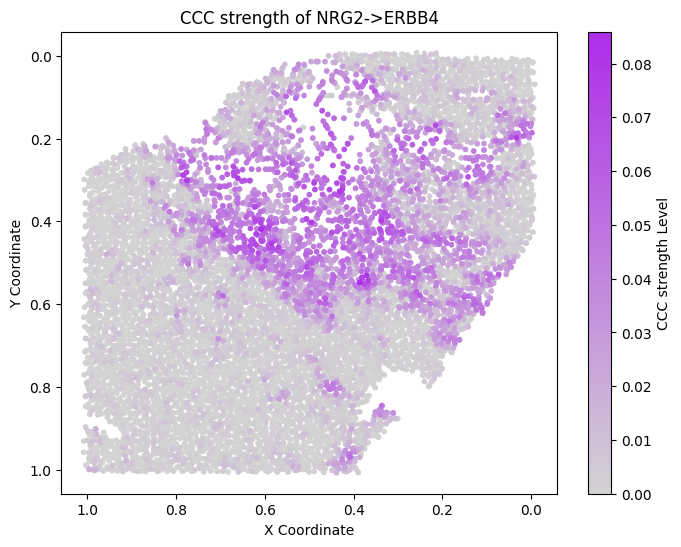

In [ ]:
gene = 'NRG2->ERBB4'
gene_expression = LRI_score[gene]

coord_cell_type = cell_loc.copy()
merged_data = coord_cell_type.join(gene_expression.rename('expression'))
merged_data = merged_data.sort_values(by='expression')

plt.figure(figsize=(8, 6))
colors = ["#D3D3D3", "#AD2DE9"]
cmap_custom = LinearSegmentedColormap.from_list("lightgray_to_blue", colors)
sc = plt.scatter(merged_data['x'], merged_data['y'], c=merged_data['expression'], cmap=cmap_custom, s=10)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.colorbar(sc, label='CCC strength Level')
plt.title(f'CCC strength of {gene}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

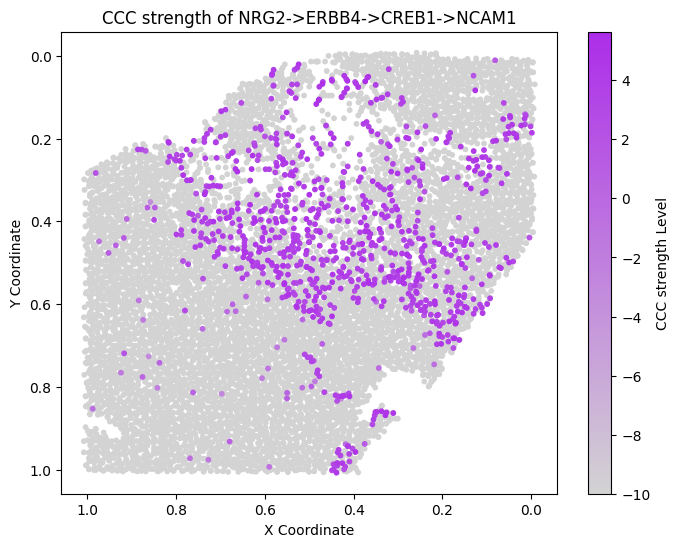

In [43]:
gene = 'NRG2->ERBB4->CREB1->NCAM1'
data = ccc[gene]
gene_expression = np.log10(data*10**9+ 1e-10)

coord_cell_type = cell_loc.copy()
merged_data = coord_cell_type.join(gene_expression.rename('expression'))
merged_data = merged_data.sort_values(by='expression')

plt.figure(figsize=(8, 6))
colors = ["#D3D3D3", "#AD2DE9"]
cmap_custom = LinearSegmentedColormap.from_list("lightgray_to_blue", colors)
sc = plt.scatter(merged_data['x'], merged_data['y'], c=merged_data['expression'], cmap=cmap_custom, s=10)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.colorbar(sc, label='CCC strength Level')
plt.title(f'CCC strength of {gene}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## The communication direction only for the significant spots for focused pair/path

In [4]:
from matplotlib.patches import FancyArrowPatch, ArrowStyle

In [5]:
color_map = {
    'Cardiomyocyte': '#1f77b4',       
    'Fibroblast': '#ff7f0e',       
    'Endothelial': '#2ca02c',      
    'Myeloid': '#d62728',          
    'Pericyte': '#9467bd',    
    'Lymphoid': '#8c564b',        
    'vSMCs': '#e377c2',           
    'Neuronal': '#bcbd22'              
}

coord_df = cell_loc.copy() 
coord_df['color'] = cell_clus['cell_type'].map(color_map)

In [16]:
Nei_adj = pd.read_csv(base_path + 'CCC/Nei_adj.csv', sep='\t', index_col=None, header=None) 
lr_with_pathway = pd.read_csv(base_path + 'inputs/LRpairDB_merge_with_pathway.csv', sep=',') 
lr_with_pathway['LR_Symbol'] = lr_with_pathway['Ligand_Symbol'] + '->' + lr_with_pathway['Receptor_Symbol']
adj = MC.Visualization.get_sender_adj(Nei_adj, cell_clus) 
Sig_LR = pd.read_csv(base_path + 'CCC/Sig_Res/Significant_LRs.csv')
pathway_mapping = lr_with_pathway.set_index('LR_Symbol')['Pathway_Name'].to_dict() 
Sig_LR['Pathway_Name'] = Sig_LR['LR_Symbol'].map(pathway_mapping)
pathway_name = 'NRG2->ERBB4'
res_all_df = MC.Visualization.get_Sig_all_vectors(pathway_name, Sig_LR, cell_clus, cell_loc, adj,mode='LR_Symbol')
res_weighted_df = MC.Visualization.get_Sig_weighted_one_vector(res_all_df)
res_weighted_df.head()

,Sample_Name,Inter_Score,Z_Score,Sender,Sender_x,Sender_y,Receiver_x,Receiver_y
0,CK166#AAACTGCAGTTCGCGC-1,0.038430,2.362531,288,0.585062,0.500497,0.585118,0.498035
1,CK166#AAACTGCAGTTCGCGC-1,0.035795,2.362531,289,0.583303,0.505925,0.581325,0.507721
2,CK166#AAACTGCAGTTCGCGC-1,0.039590,2.362531,3155,0.593132,0.494246,0.590350,0.495077
3,CK166#AAACTGCAGTTCGCGC-1,0.039461,2.362531,3156,0.595441,0.494545,0.592421,0.494279
4,CK166#AAACTGCAGTTCGCGC-1,0.044734,2.362531,3420,0.599328,0.507097,0.602225,0.506456


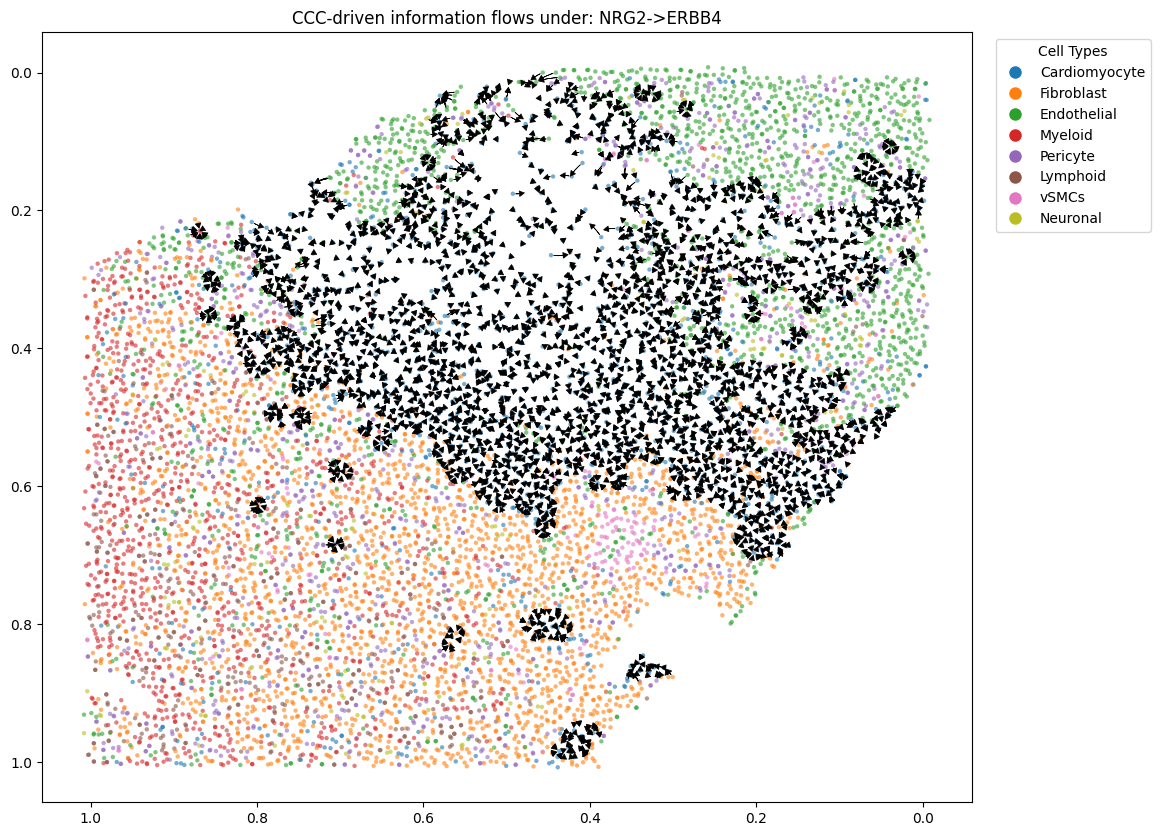

In [17]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(coord_df['x'], coord_df['y'],
                     c=coord_df['color'], alpha=0.6, s=10, linewidths=0) 
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis()
for index, row in res_weighted_df.iterrows():
    strength = row['Inter_Score']
    lw = max(0.5, strength * 1e1)
    arrowstyle = ArrowStyle("Simple", head_length=1.8, head_width=2, tail_width=0.01)
    arrow = FancyArrowPatch((row['Sender_x'],row['Sender_y']), 
                            (row['Receiver_x'], row['Receiver_y']),
                            connectionstyle="arc3,rad=0.1", 
                            arrowstyle=arrowstyle, color='black', lw=lw,
                            mutation_scale=2)
    plt.gca().add_patch(arrow)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=10)
           for celltype, color in color_map.items()]
plt.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.20, 1), loc= 'upper right')

plt.title('CCC-driven information flows under: '+ pathway_name)
plt.show()

## The two-hop signaling events for the significant spots for focused pair/path

In [4]:
Sig_path = pd.read_csv(base_path + 'CCC/Significant_paths_res.csv')
condition = Sig_path['path_symbol'].str.startswith('NCAM1')
pair1 = 'NRG2->ERBB4->CREB1->NCAM1' 

In [ ]:
sig_x_relay_y = MC.Visualization.get_two_hop_cascade_vectors(Sig_path, condition, pair1)
pair2 = 'NCAM1->FGFR1->JUN->DTNA' 
cur_df = sig_x_relay_y[(sig_x_relay_y['XR_Path_Symbol'] == pair1) & (sig_x_relay_y['RY_Path_Symbol'] == pair2)] 
cur_df.head()

,X_name,Relay_name,Y_name,XR_Path_Symbol,RY_Path_Symbol,XR_Comm_Score,RY_Comm_Score
22,CK171#GTTGGGCAGACGCCAA-1,CK171#GTTGGGCAGACGCCAA-1,CK169#GACTAACCACGATATC-1,NRG2->ERBB4->CREB1->NCAM1,NCAM1->FGFR1->JUN->DTNA,0.000053,0.000002
131,CK169#GAGTGAGCACAACGGA-1,CK171#GTTGGGCAGACGCCAA-1,CK169#GACTAACCACGATATC-1,NRG2->ERBB4->CREB1->NCAM1,NCAM1->FGFR1->JUN->DTNA,0.000053,0.000002
240,CK353#GGATAGGAGGAGAACA-1,CK171#GTTGGGCAGACGCCAA-1,CK169#GACTAACCACGATATC-1,NRG2->ERBB4->CREB1->NCAM1,NCAM1->FGFR1->JUN->DTNA,0.000053,0.000002
349,CK171#CTCCCAATCACGGGTC-1,CK171#GTTGGGCAGACGCCAA-1,CK169#GACTAACCACGATATC-1,NRG2->ERBB4->CREB1->NCAM1,NCAM1->FGFR1->JUN->DTNA,0.000053,0.000002
458,CK340#CCTATTACATCCTGGG-1,CK171#GTTGGGCAGACGCCAA-1,CK169#GACTAACCACGATATC-1,NRG2->ERBB4->CREB1->NCAM1,NCAM1->FGFR1->JUN->DTNA,0.000053,0.000002


In [40]:
cur_xr = pd.DataFrame({
    'sender_x': cur_df['X_name'].map(coord_df['x']),
    'sender_y': cur_df['X_name'].map(coord_df['y']),
    'receiver_x': cur_df['Relay_name'].map(coord_df['x']),
    'receiver_y': cur_df['Relay_name'].map(coord_df['y']),
    'score': cur_df['XR_Comm_Score']
})
cur_ry = pd.DataFrame({
    'sender_x': cur_df['Relay_name'].map(coord_df['x']),
    'sender_y': cur_df['Relay_name'].map(coord_df['y']),
    'receiver_x': cur_df['Y_name'].map(coord_df['x']),
    'receiver_y': cur_df['Y_name'].map(coord_df['y']),
    'score': cur_df['RY_Comm_Score']
})

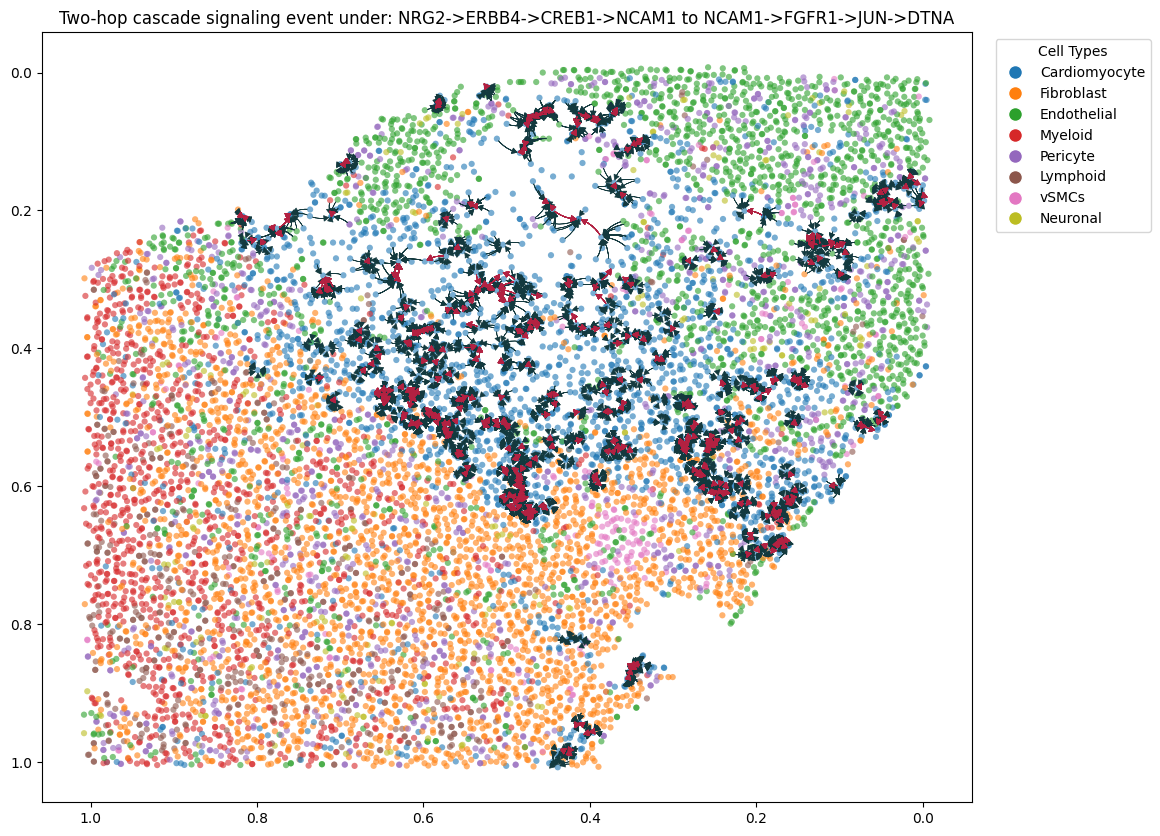

In [41]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(coord_df['x'], coord_df['y'],
                     c=coord_df['color'], alpha=0.6, s=20, linewidths=0) 
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis()
for index, row in cur_xr.iterrows():
    strength = row['score']
    lw = max(0.5, strength * 1e1)
    arrowstyle = ArrowStyle("Simple", head_length=1.8, head_width=2, tail_width=0.01)
    arrow = FancyArrowPatch((row['sender_x'],row['sender_y']), 
                            (row['receiver_x'], row['receiver_y']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='#13393E', lw=lw,
                            mutation_scale=2)
    plt.gca().add_patch(arrow)
    
for index, row in cur_ry.iterrows():
    strength = row['score']
    lw = max(0.5, strength * 1e1)
    arrowstyle = ArrowStyle("Simple", head_length=1.8, head_width=2, tail_width=0.01)
    arrow = FancyArrowPatch((row['sender_x'],row['sender_y']), 
                            (row['receiver_x'], row['receiver_y']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='#B32142', lw=lw,
                            mutation_scale=2)
    plt.gca().add_patch(arrow)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=10)
           for celltype, color in color_map.items()]
plt.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.20, 1), loc= 'upper right')


plt.title('Two-hop cascade signaling event under: '+  pair1 + ' to ' + pair2)
plt.show()

## The abundance and cell-type-specific enrichment

In [5]:
import plotly.express as px

In [6]:
ccc = pd.read_csv(base_path + 'CCC/L_R_TF_TG/TG_cascade_results/NOTCH4.csv',index_col=0)  
sig_ccc = pd.read_csv(base_path + 'CCC/Stats_results_TG/Significant_paths_NOTCH4.csv', sep=',', index_col=None)
ct_target = 'Endothelial'
condition = (Sig_path['path_symbol'].str.endswith('STAT2->NOTCH4')) & (Sig_path['target'] == ct_target)
cauchy_df = MC.Visualization.get_cauchy_res(ct_target, condition,Sig_path,sig_ccc,cell_clus)

Fixed top 20 paths for Endothelial target:
['EGF->EGFR->STAT2->NOTCH4', 'IL15->IL15RA_IL2RB_IL2RG->STAT2->NOTCH4', 'KITLG->EGFR->STAT2->NOTCH4', 'MIF->CD74_CXCR4->STAT2->NOTCH4', 'IL15->IL15RA->STAT2->NOTCH4', 'FGF1->EGFR->STAT2->NOTCH4', 'BTC->EGFR->STAT2->NOTCH4', 'OSM->IL6ST_OSMR->STAT2->NOTCH4', 'AREG->EGFR->STAT2->NOTCH4', 'LIF->IL6ST_LIFR->STAT2->NOTCH4', 'VEGFA->EGFR->STAT2->NOTCH4', 'HBEGF->EGFR->STAT2->NOTCH4', 'CTF1->IL6ST->STAT2->NOTCH4', 'HBEGF->ERBB2_EGFR->STAT2->NOTCH4', 'IL10->IL10RA_IL10RB->STAT2->NOTCH4', 'EGF->ERBB2_EGFR->STAT2->NOTCH4', 'IL6->IL6ST->STAT2->NOTCH4', 'CTF1->IL6ST_LIFR->STAT2->NOTCH4', 'LIF->LIFR->STAT2->NOTCH4', 'KITLG->PDGFRB->STAT2->NOTCH4']


In [18]:
cauchy_df.to_csv(base_path + 'Figures/STAT2-NOTCH4_Endothelial_cauchy.csv', sep=',', index=False)

In [6]:
comm_counts_df = Sig_path.groupby(['path_symbol', 'target']).size().reset_index(name='comm_count')
comm_counts_df = comm_counts_df.rename(columns={'path_symbol': 'pathway', 'target': 'type'})
cauchy_df = cauchy_df.merge(comm_counts_df, on=['pathway', 'type'], how='left')
cauchy_df['comm_count'] = cauchy_df['comm_count'].fillna(0).astype(int)

In [7]:
fig = px.scatter(cauchy_df, x='pathway', y='neg_log10_p', color='type', size='neg_log10_p') 
fig.show()

In [16]:
import subprocess 
import os 
import sys

In [20]:
base_path = "/home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/"
input_file = os.path.join(base_path, "Figures/STAT2-NOTCH4_Endothelial_cauchy.csv")
output_dir = os.path.join(base_path, "Figures/")
r_script_path = "/home/nas3/biod/zhencaiwei/MultiChat-main/MultiChat/Plot/Paths_bubble_abun_cauchy.R"

subprocess.run([
    "Rscript",
    r_script_path,
    input_file,
    output_dir
], check=True)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead. 


Plot saved to: /home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/Figures//CauchyP_Dot_plot.png 


CompletedProcess(args=['Rscript', '/home/nas3/biod/zhencaiwei/MultiChat-main/MultiChat/Plot/Paths_bubble_abun_cauchy.R', '/home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/Figures/STAT2-NOTCH4_Endothelial_cauchy.csv', '/home/nas3/biod/zhencaiwei/MultiChat-main/Datasets/HumanHeart/Figures/'], returncode=0)

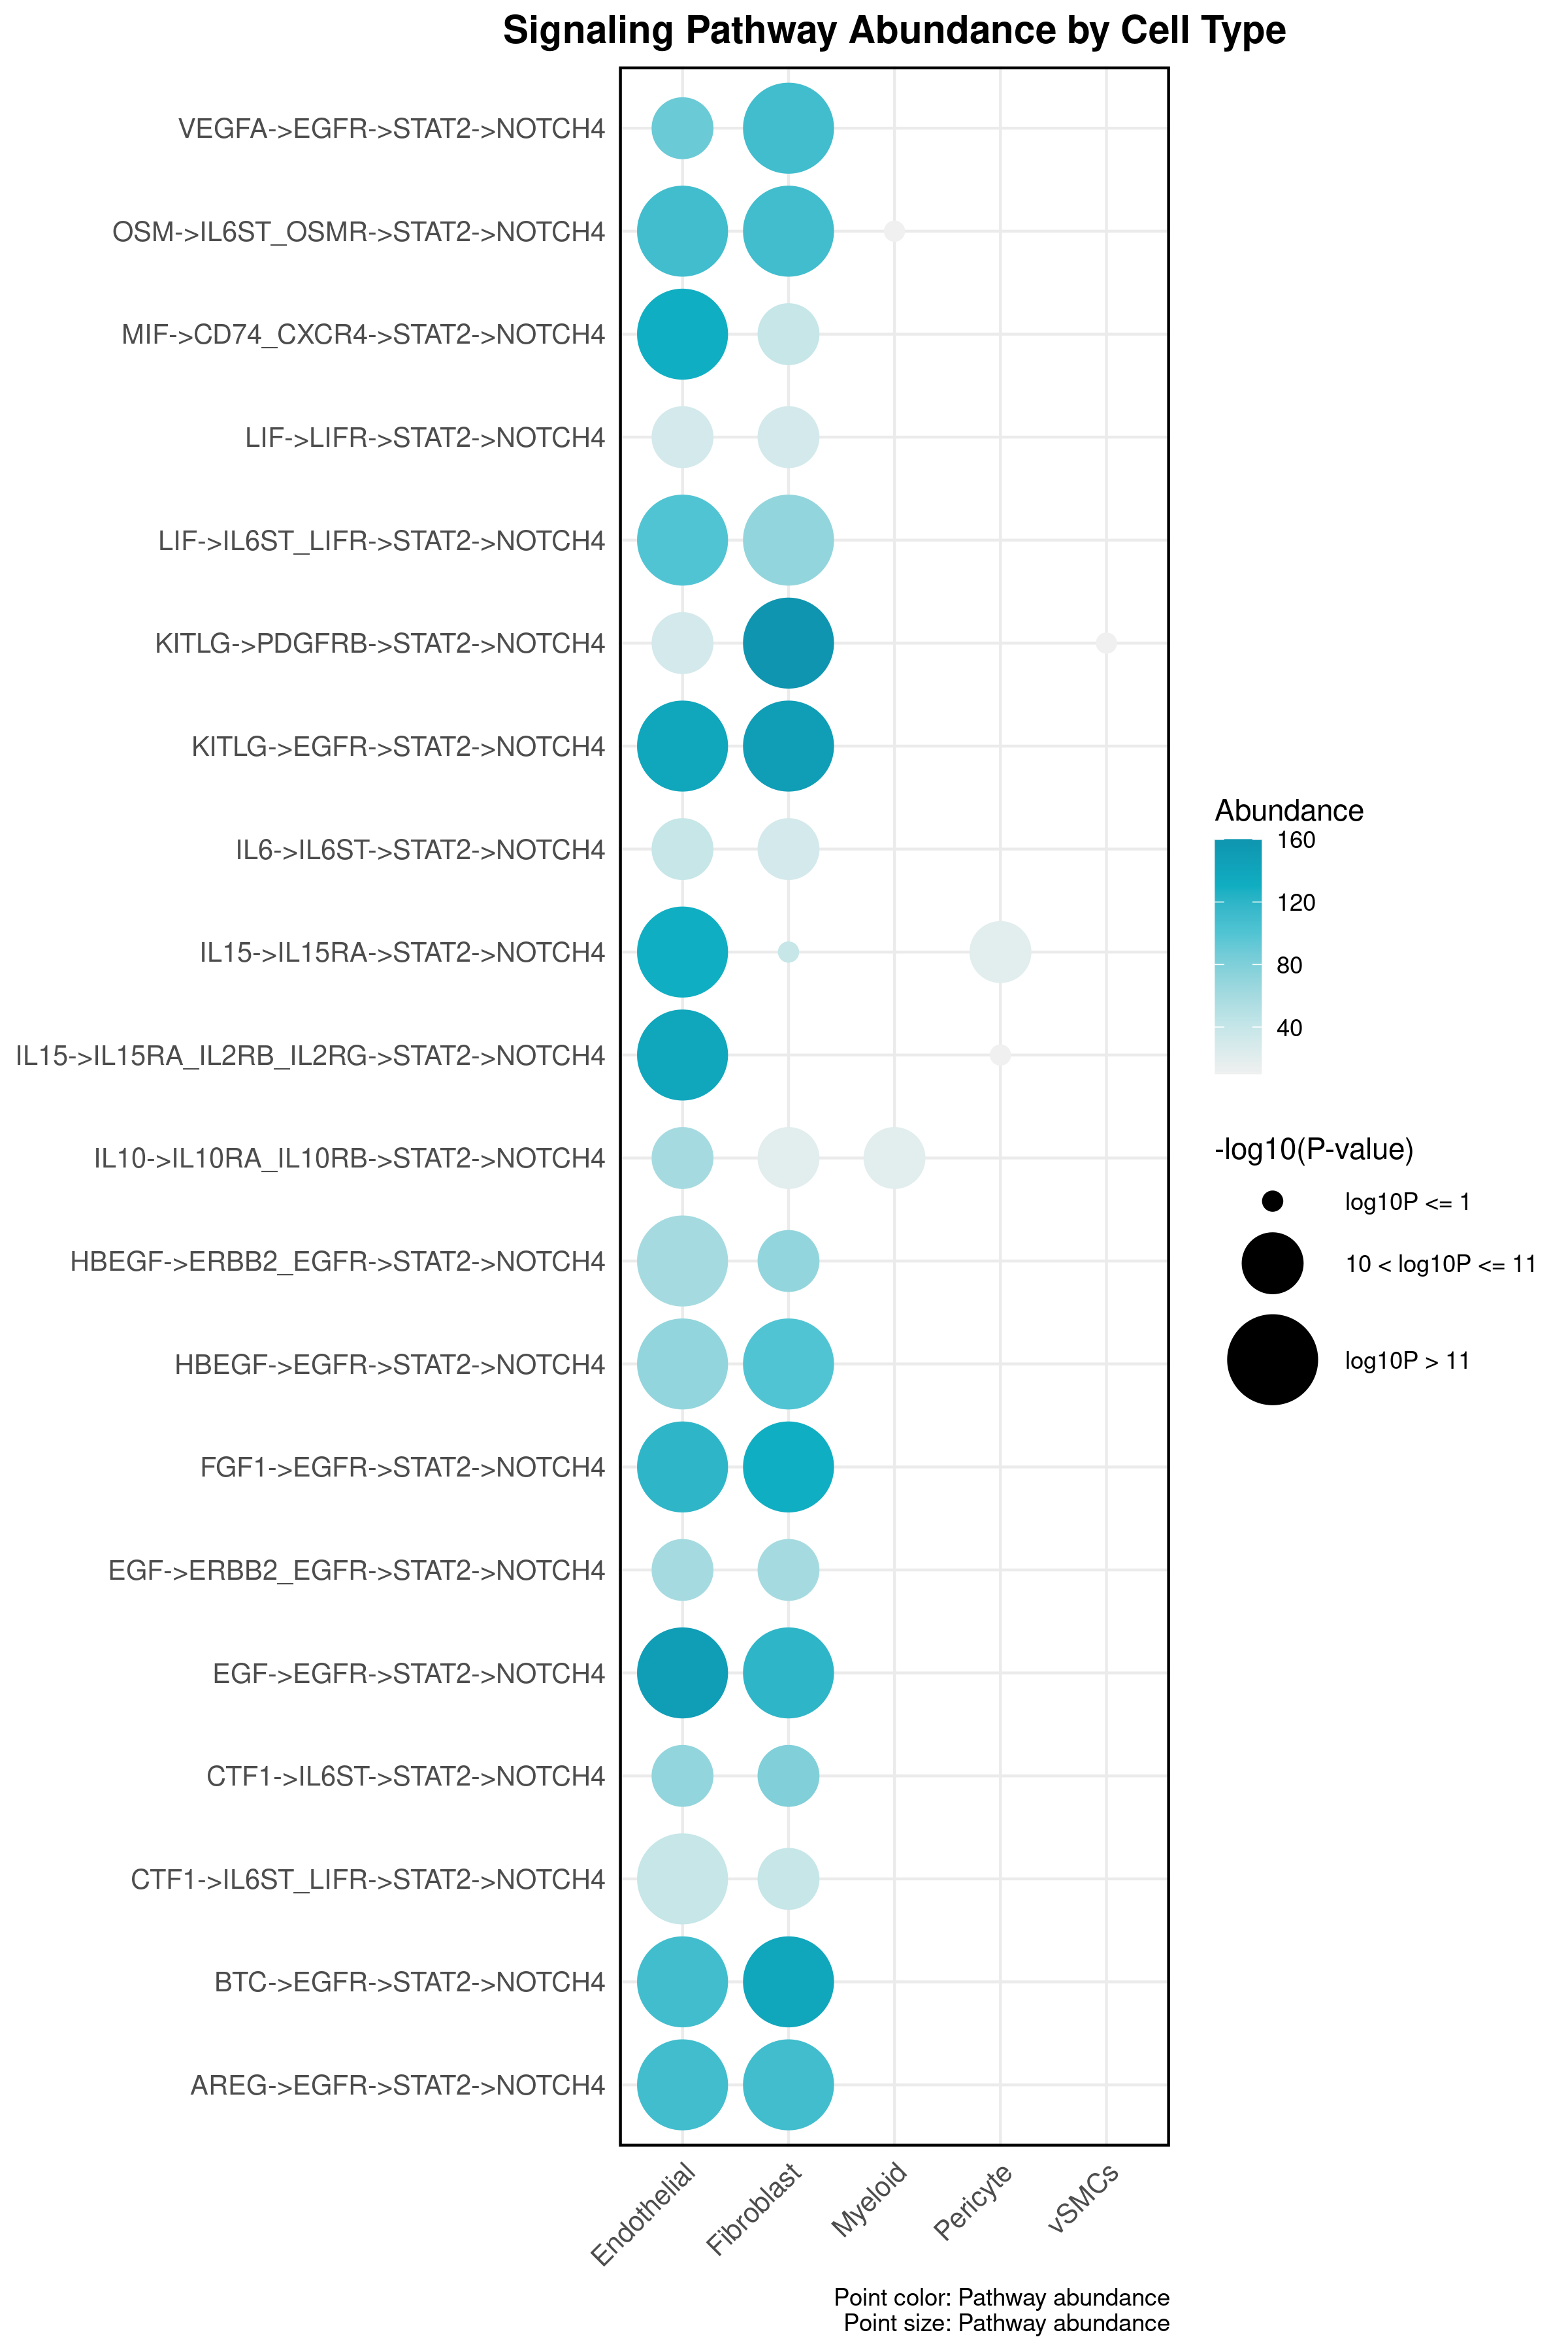

In [22]:
from IPython.display import Image, display
png_file = os.path.join(output_dir, "CauchyP_Dot_plot.png")
if os.path.exists(png_file):
    display(Image(filename=png_file, width=600, height=400))